In [1]:
import os

mask_dir = "Data/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images"
image_dir = "Data/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images"

images_name = os.listdir(image_dir)

print(len(images_name))

1100


RGB
RGB
RGB
RGB
RGB
RGB


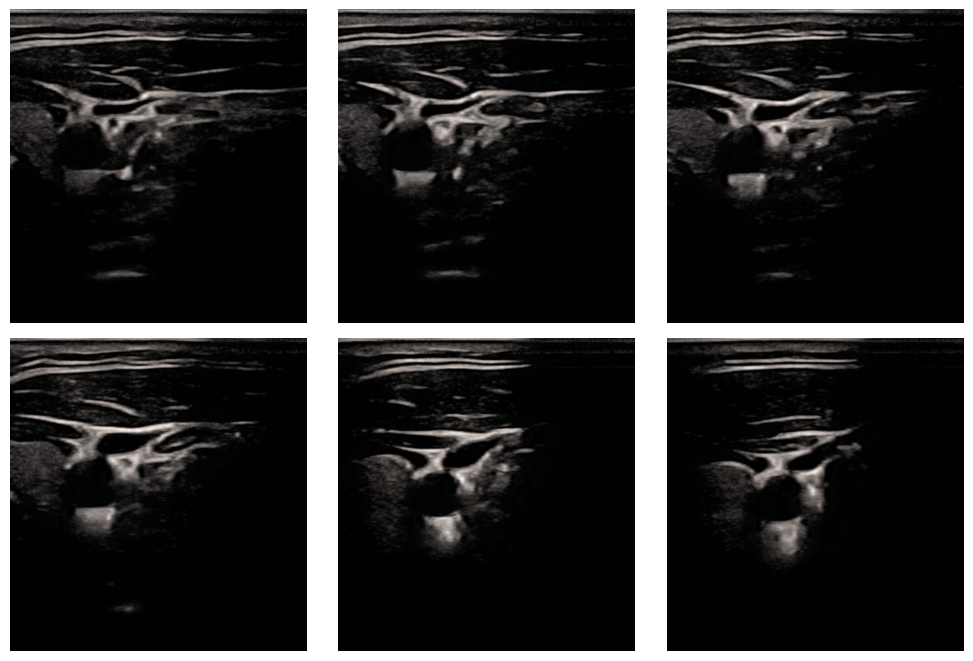

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

num_samples = 6

plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(3, 3, i+1)
    img_path = os.path.join(image_dir, images_name[i])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    print(img.mode)

plt.tight_layout()
plt.show()

L
[  0 255]
L
[  0 255]
L
[  0 255]
L
[  0 255]
L
[  0 255]
L
[  0 255]


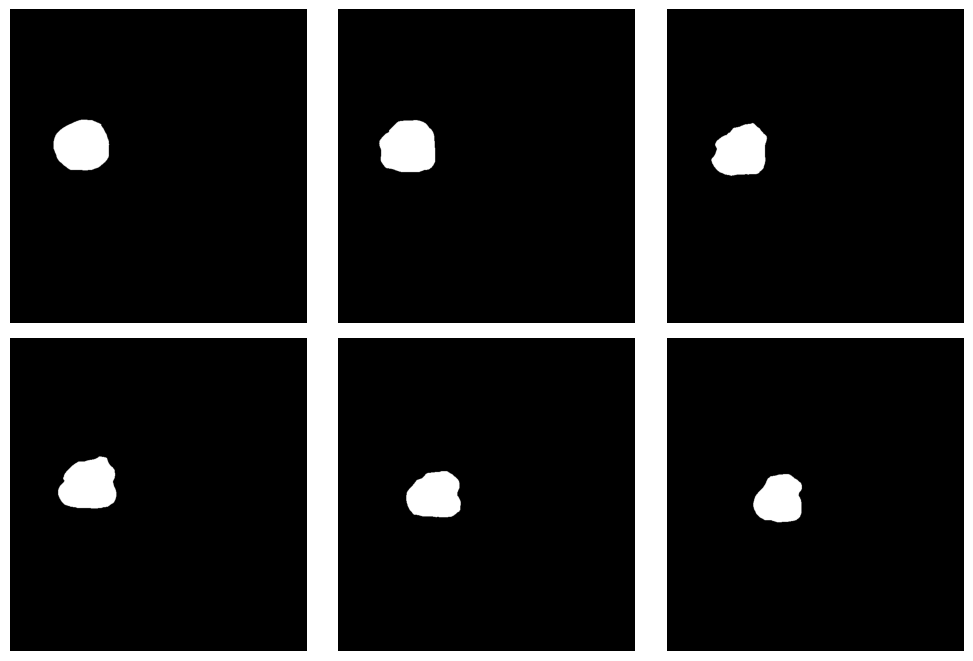

In [3]:
import numpy as np
num_samples = 6

plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(3, 3, i+1)
    img_path = os.path.join(mask_dir, images_name[i])
    img = Image.open(img_path)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    print(img.mode)
    print(np.unique(img))

plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs = train_test_split(images_name, test_size=0.2, random_state=42)

print(len(train_imgs), len(val_imgs))

880 220


In [5]:
import tensorflow as tf

def create_tf_dataset(images_name):
    def generator():
        for name in images_name:
            img_path = os.path.join(image_dir, name)
            mask_path = os.path.join(mask_dir, name)

            img = Image.open(img_path)
            mask = Image.open(mask_path)

            yield img, mask

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec((None, None, 3), dtype=tf.float32),
            tf.TensorSpec((None, None), dtype=tf.uint8)
        )
    )

train_dataset = create_tf_dataset(train_imgs)
val_dataset = create_tf_dataset(val_imgs)

In [6]:
def preprocessing(img, mask):
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (224, 224))
    mask = tf.cast(mask, dtype=tf.float32) / 255.0

    return img, mask

train_dataset = train_dataset.map(preprocessing)
val_dataset = val_dataset.map(preprocessing)

In [7]:
train_dataset = train_dataset.repeat().batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(8).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = 880 // 8
validation_steps = 220 // 8

In [8]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate

In [9]:
def downsampling_block(inputs, n_filters, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.

    Args:
        inputs: Input tensor.
        n_filters: Number of filters for convolutional layers.
        dropout_prob: Dropout probability.
        max_pooling: Whether to apply max pooling.

    Returns:
        next_layer: Output tensor for the next layer.
        skip_connection: Skip connection tensor.
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
    return next_layer, conv

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block.

    Args:
        expansive_input: Input tensor from previous layer.
        contractive_input: Skip connection tensor from encoding path.
        n_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor after upsampling and convolution.
    """
    up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [11]:
import keras


def unet_model(input_size=(224, 224, 3), n_filters=32, n_classes=1):
    """
    U-Net model implementation.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model.
    """
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters * 2)
    dblock3 = downsampling_block(dblock2[0], n_filters * 4)
    dblock4 = downsampling_block(dblock3[0], n_filters * 8)
    dblock5 = downsampling_block(dblock4[0], n_filters * 16)
    #Bottleneck
    bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout_prob=0.4, max_pooling=False)

    # Expanding Path (Decoder)
    ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16)
    ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4)
    ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2)
    ublock11 = upsampling_block(ublock10, dblock1[1], n_filters)

    # Output Layer
    conv12 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock11)
    outputs = Conv2D(n_classes, 1, activation="sigmoid", padding="same")(conv12)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [12]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [14]:
model = unet_model(n_filters=32)

metrics = ["accuracy", dice_coef]

model.compile(optimizer="adam", loss=combined_loss, metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 7, 7, 512) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 7, 7,      │  4,719,616 │ max_pooling2d_4[

 Total params: 34,595,585 (131.97 MB)

 Trainable params: 34,595,585 (131.97 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9652 - dice_coef: 0.2067 - loss: 0.5780 - val_accuracy: 0.9914 - val_dice_coef: 0.7839 - val_loss: 0.1464 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9944 - dice_coef: 0.8860 - loss: 0.0783 - val_accuracy: 0.9940 - val_dice_coef: 0.8731 - val_loss: 0.0910 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9808 - dice_coef: 0.5381 - loss: 1.6047 - val_accuracy: 0.9754 - val_dice_coef: 0.0498 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9709 - dice_coef: 0.0754 - loss: 0.6062 - val_accuracy: 0.9720 - val_dice_coef: 0.1940 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9701 - dice_coef: 0.1291 - loss: 0.5674 - val_accuracy: 0.9675 - val_dice_coef: 0.4019 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 6/20
110/

In [20]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    batch = next(iter(dataset))
    images, masks = batch

    num_samples = min(images.shape[0], num_samples)

    predictions = model.predict(images)

    # Binarizing prediction masks
    binary_predictions = (predictions > threshold).astype('uint8')

    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


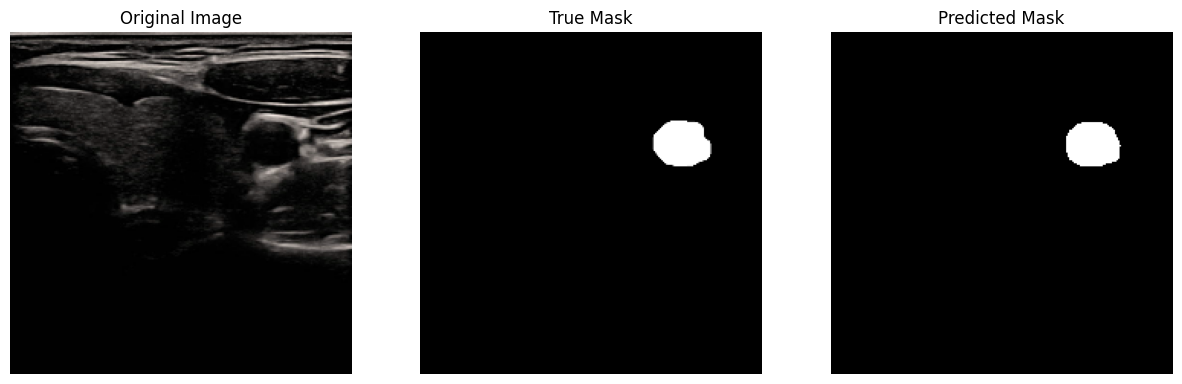

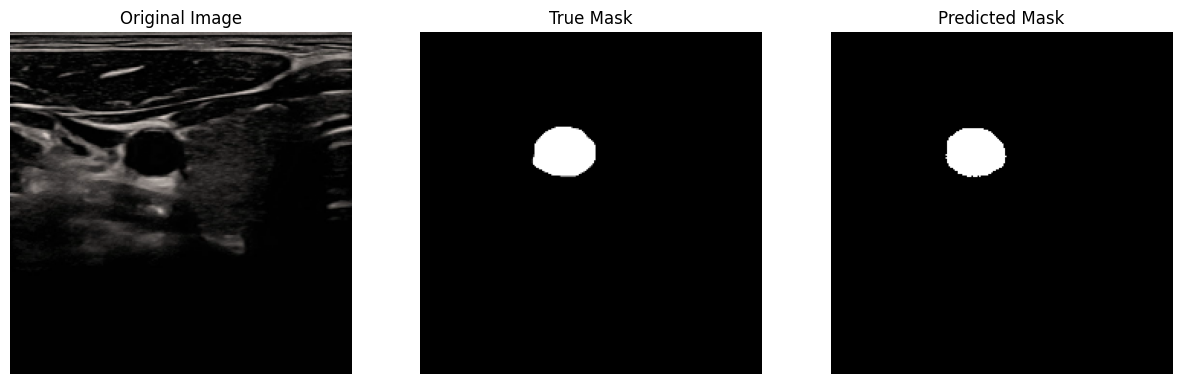

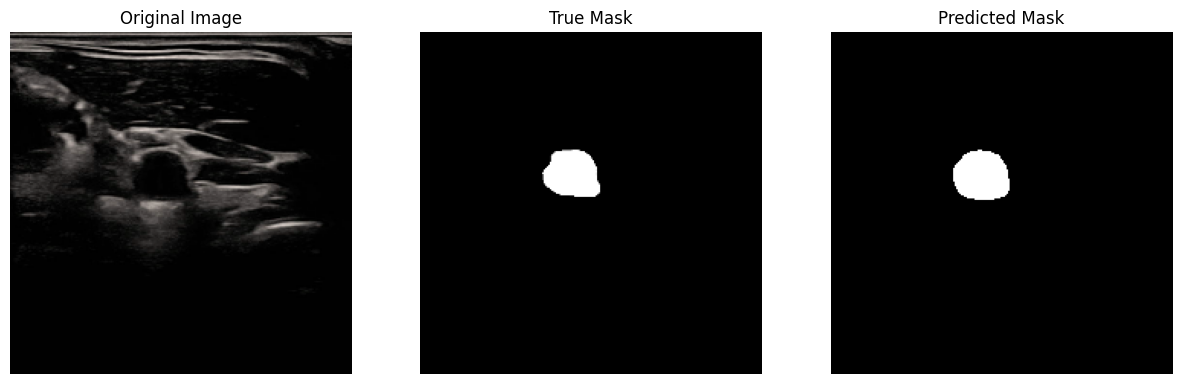

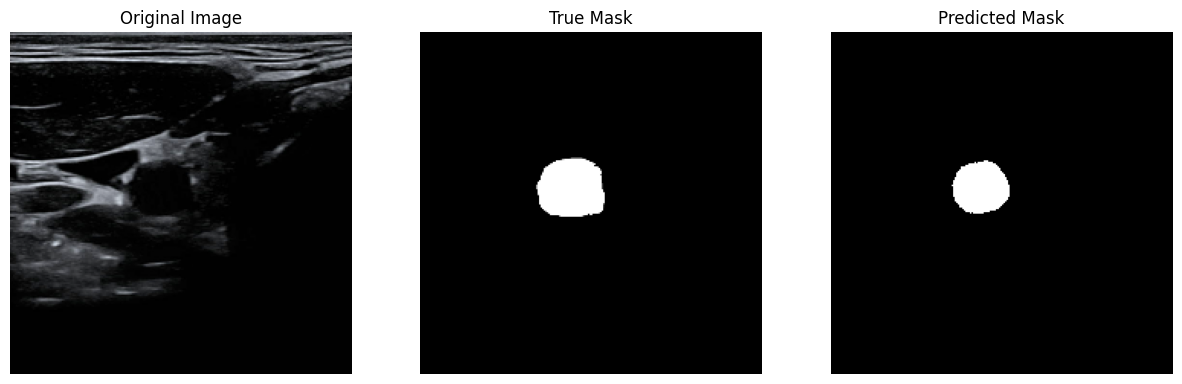

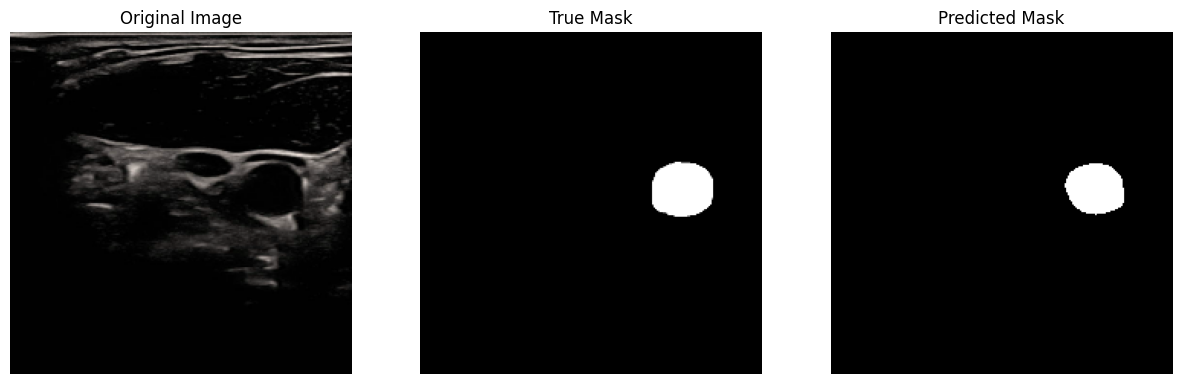

In [21]:
visualize_predictions(model, val_dataset)